# Instrumental Variable Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 


In [15]:
import pandas as pd
import patsy as ps
from statsmodels.sandbox.regression.gmm import IV2SLS
import statsmodels

import pygraphviz
import dowhy
from dowhy import CausalModel
import econml


import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from econml.deepiv import DeepIVEstimator


from econml.inference import BootstrapInference
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

random_state = 42
import keras
from econml.deepiv import DeepIVEstimator

# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
from IPython.display import Image, display



In [16]:
from pathlib import Path
import os
import sys

cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')

In [17]:
sys.path.append(SCRIPT_DIR)

In [18]:
import dowhy_helpers as dwh

In [19]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve Estimation (no causal inference)

In [20]:
# Dataset without dropping burrhole_num NA patients
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---
## I. Model a causal problem

### Note the `mp_model` is not included since this model contains to instruments 
* Create a causal model from the data and given graph.

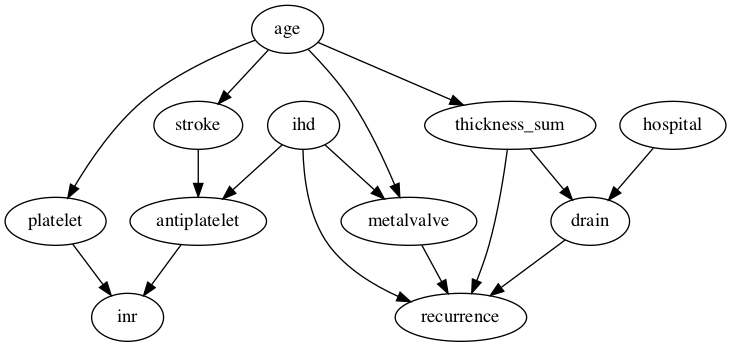

In [21]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
data_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [22]:
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Instrumental variable (IV; hospital) estimator

### This estimate applies to the `data_model` and `small_data_model` only; `mp_model` contains no instruments.

The instrumental variables approach attempts to estimate the effect of $T$ on $Y$ with the help of a third variable  $Z$ that is correlated with $T$ but is uncorrelated with the error term for $Y$. In other words, the instrument $Z$ is only related with $Y$ through the directed path that goes through $T$. If these conditions are satisfied, the effect of $T$ on $Y$ can be estimated using the sample analog of:

$$\frac{Cov(Y_i, Z_i)}{Cov(T_i, Z_i)}$$

The most common method for instrumental variables estimation is the two-stage least squares (2SLS). In this approach, the cause variable $T$ is first regressed on the instrument $Z$. Then, in the second stage, the outcome of interest $Y$ is regressed on the predicted value from the first-stage model. Intuitively, the effect of $T$ on $Y$ is estimated by using only the proportion of variation in $T$ due to variation in $Z$. See https://www.aeaweb.org/articles?id=10.1257/jep.15.4.69  for a detailed discussion of the method.

In [23]:
# 2SLS estimate method since instrument (hospital) is categorical
data_iv_est = data_model.estimate_effect(data_estimand,
                                         control_value=0,
                                         treatment_value=1,
                                         method_name='iv.instrumental_variable',
                                         method_params={'iv_instrument_name': 'hospital'},
                                         test_significance=True, 
                                         confidence_intervals=True)

In [24]:
print(data_iv_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(recurrence, hospital))⋅Expectation(Derivative(drain, ho

        -1
spital))  
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['drain'] is affected in the same way by common caus

In [25]:
# Two-Stage Least-Squares (2SLS) Regression
# We see congruence between this and the DoWhy method
rec_vec, endog = ps.dmatrices("recurrence ~ drain", data=csdh)
exog = ps.dmatrix("hospital", data=csdh)

m = IV2SLS(rec_vec, endog, exog).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:             recurrence   R-squared:                      -0.043
Model:                         IV2SLS   Adj. R-squared:                 -0.045
Method:                     Two Stage   F-statistic:                     1.067
                        Least Squares   Prob (F-statistic):              0.302
Date:                Thu, 15 Jul 2021                                         
Time:                        16:24:54                                         
No. Observations:                 745                                         
Df Residuals:                     743                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3273      0.228      1.439      0.151      -0.119       0.774
drain         -0.2811      0.272     -1.033      0.302      -0.815       0.253
==============================================================================
Omnibus:                      352.300   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1397.168
Skew:                           2.296   Prob(JB):                    4.06e-304
Kurtosis:                       7.891   Cond. No.                         4.73
==============================================================================
"""

## For IV methods, only the treatment, outcome and instrument are important; the rest of the causal graph is ignored.


In [26]:
# data model
dwh.print_estimate_comparison(naive_est, data_iv_est, 'Instrumental variable')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Instrumental variable causal estimate is -0.2811003905742171
Percentage change from naive_est: 200.445%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [27]:
# Robust if: estimate stays the same
iv_ran_refuter = data_model.refute_estimate(data_estimand, data_iv_est,
                                            num_simulations=100,
                                            random_state=random_state,
                                            method_name="random_common_cause")

2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [28]:
# Robust if: estimate goes to 0
iv_placebo_refuter = data_model.refute_estimate(data_estimand, data_iv_est,
                                                method_name="placebo_treatment_refuter",
                                                num_simulations=100,
                                                placebo_type='permute')

3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [29]:
#### NOT APPLICABLE TO IV ESTIMATION METHODS ########
# Robust if: estimate goes to 0
# iv_dummy_refuter = data_model.refute_estimate(data_estimand,
#                                               data_iv_est,
#                                               method_name="dummy_outcome_refuter")

4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [30]:
# Robust if: estimate stays the same
iv_subset_refuter = data_model.refute_estimate(data_estimand, data_iv_est,
                                               method_name="data_subset_refuter",
                                               num_simulations=100,
                                               random_state=random_state,
                                               subset_fraction=0.75)

5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [32]:
# Robust if: estimate stays the same
iv_bootstrap_refuter = data_model.refute_estimate(data_estimand, data_iv_est,
                                                  method_name="bootstrap_refuter", 
                                                  random_state=random_state,
                                                  num_simulations=100)

In [33]:
print(iv_ran_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.2811003905742171
New effect:-0.2811003905742171



In [34]:
print(iv_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.2811003905742171
New effect:-0.004524104251097784
p value:0.47



In [35]:
print(iv_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.2811003905742171
New effect:-0.12467038251140067
p value:0.0



In [36]:
print(iv_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.2811003905742171
New effect:-0.3137110337995069
p value:0.0



---
# ~~Deep IV Estimator~~ - abandoned due to issues with validation

In [55]:
dims_zx = len(small_data_model._instruments)+len(small_data_model._effect_modifiers)
dims_tx = len(small_data_model._treatment)+len(small_data_model._effect_modifiers)

In [56]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(26, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1, activation='sigmoid')])

In [57]:
small_deepiv_estimate = small_data_model.estimate_effect(small_data_estimand,
                                                         method_name="iv.econml.iv.nnet.DeepIV",
                                                         control_value=0,
                                                         treatment_value=1,
                                                         confidence_intervals=False,
                                                         target_units='ate',
                                                         method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                                                       'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                                                       "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                                                       'n_samples': 100, # Number of samples used to estimate the response
                                                                                       'first_stage_options':{'epochs':500},
                                                                                       'second_stage_options':{'epochs':20}
                                                                                      },
                                                                        "fit_params":{}
                                                                       }
                                                        )

Epoch 1/500
745/745 [==============================] - 31s 42ms/step - loss: 0.5664
Epoch 2/500
745/745 [==============================] - 0s 619us/step - loss: 0.3002
Epoch 3/500
745/745 [==============================] - 0s 569us/step - loss: 0.2212
Epoch 4/500
745/745 [==============================] - 0s 630us/step - loss: 0.1674
Epoch 5/500
745/745 [==============================] - 0s 623us/step - loss: 0.0701
Epoch 6/500
745/745 [==============================] - 0s 643us/step - loss: -0.0264
Epoch 7/500
745/745 [==============================] - 0s 603us/step - loss: -0.0622
Epoch 8/500
745/745 [==============================] - 0s 595us/step - loss: -0.1568
Epoch 9/500
745/745 [==============================] - 0s 590us/step - loss: -0.2419
Epoch 10/500
745/745 [==============================] - 0s 600us/step - loss: -0.2786
Epoch 11/500
745/745 [==============================] - 0s 608us/step - loss: -0.3323
Epoch 12/500
745/745 [==============================] - 0s 577us/ste

745/745 [==============================] - 1s 711us/step - loss: -4.7936
Epoch 191/500
745/745 [==============================] - 1s 821us/step - loss: -4.7047
Epoch 192/500
745/745 [==============================] - 1s 770us/step - loss: -4.6273
Epoch 193/500
745/745 [==============================] - 1s 757us/step - loss: -4.6665
Epoch 194/500
745/745 [==============================] - 1s 766us/step - loss: -4.7673
Epoch 195/500
745/745 [==============================] - 1s 778us/step - loss: -4.8067
Epoch 196/500
745/745 [==============================] - 1s 795us/step - loss: -4.7938
Epoch 197/500
745/745 [==============================] - 1s 777us/step - loss: -4.8602
Epoch 198/500
745/745 [==============================] - 1s 780us/step - loss: -4.8932
Epoch 199/500
745/745 [==============================] - 1s 801us/step - loss: -4.8977
Epoch 200/500
745/745 [==============================] - 1s 793us/step - loss: -4.8470
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 0s 594us/step - loss: -6.2800
Epoch 379/500
745/745 [==============================] - 0s 588us/step - loss: -6.4702
Epoch 380/500
745/745 [==============================] - 0s 612us/step - loss: -3.7670
Epoch 381/500
745/745 [==============================] - 0s 628us/step - loss: -3.9097
Epoch 382/500
745/745 [==============================] - 0s 633us/step - loss: -6.0523
Epoch 383/500
745/745 [==============================] - 1s 683us/step - loss: -6.3406
Epoch 384/500
745/745 [==============================] - 0s 655us/step - loss: -6.3961
Epoch 385/500
745/745 [==============================] - 0s 642us/step - loss: -6.4766
Epoch 386/500
745/745 [==============================] - 0s 588us/step - loss: -5.9773
Epoch 387/500
745/745 [==============================] - 0s 581us/step - loss: -6.0683
Epoch 388/500
745/745 [==============================] - 0s 594us/step - loss: -6.3544
Epoch 389/500
745/745 [==============================] - 

In [58]:
print(small_deepiv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

## Realized estimand
b: recurrence~drain+metalvalve+stroke+age+antiplatelet+inr+ihd+platelet+thickness_sum | ihd,metalvalve
Target units: ate

## Estimate
Mean value: -0.16557924449443817
Effect estimates: [-0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.22528201 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.22528201 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.1

In [60]:
# small data model
dwh.print_estimate_comparison(naive_est, small_deepiv_estimate, 'DeepIV')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
DeepIV causal estimate is -0.16557924
Percentage change from naive_est: 76.974%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [61]:
div_ran_refuter = small_data_model.refute_estimate(small_data_estimand,
                                                   small_deepiv_estimate, 
                                                   method_name="random_common_cause", 
                                                   num_simulations=5)

Epoch 1/500
745/745 [==============================] - 28s 37ms/step - loss: 0.3635
Epoch 2/500
745/745 [==============================] - 1s 692us/step - loss: 0.1930
Epoch 3/500
745/745 [==============================] - 1s 682us/step - loss: 0.0367
Epoch 4/500
745/745 [==============================] - 1s 702us/step - loss: -0.1236
Epoch 5/500
745/745 [==============================] - 1s 723us/step - loss: -0.2651
Epoch 6/500
745/745 [==============================] - 1s 714us/step - loss: -0.4006
Epoch 7/500
745/745 [==============================] - 1s 696us/step - loss: -0.5422
Epoch 8/500
745/745 [==============================] - 1s 703us/step - loss: -0.6728
Epoch 9/500
745/745 [==============================] - 1s 714us/step - loss: -0.8345
Epoch 10/500
745/745 [==============================] - 1s 704us/step - loss: -0.9803
Epoch 11/500
745/745 [==============================] - 1s 703us/step - loss: -1.0651
Epoch 12/500
745/745 [==============================] - 1s 710us/s

745/745 [==============================] - 0s 580us/step - loss: -3.8514
Epoch 191/500
745/745 [==============================] - 0s 567us/step - loss: -4.2860
Epoch 192/500
745/745 [==============================] - 0s 567us/step - loss: -4.2156
Epoch 193/500
745/745 [==============================] - 0s 571us/step - loss: -4.4228
Epoch 194/500
745/745 [==============================] - 0s 561us/step - loss: -4.4701
Epoch 195/500
745/745 [==============================] - 0s 585us/step - loss: -4.4723
Epoch 196/500
745/745 [==============================] - 0s 621us/step - loss: -4.4301
Epoch 197/500
745/745 [==============================] - 0s 645us/step - loss: -4.4745
Epoch 198/500
745/745 [==============================] - 0s 636us/step - loss: -4.5609
Epoch 199/500
745/745 [==============================] - 1s 678us/step - loss: -4.6547
Epoch 200/500
745/745 [==============================] - 1s 699us/step - loss: -4.6987
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 0s 564us/step - loss: -4.3394
Epoch 379/500
745/745 [==============================] - 0s 561us/step - loss: -4.5763
Epoch 380/500
745/745 [==============================] - 0s 569us/step - loss: -4.7343
Epoch 381/500
745/745 [==============================] - 0s 570us/step - loss: -4.8821
Epoch 382/500
745/745 [==============================] - 0s 563us/step - loss: -4.7418
Epoch 383/500
745/745 [==============================] - 0s 557us/step - loss: -4.7548
Epoch 384/500
745/745 [==============================] - 0s 575us/step - loss: -4.7973
Epoch 385/500
745/745 [==============================] - 0s 583us/step - loss: -4.8854
Epoch 386/500
745/745 [==============================] - 0s 588us/step - loss: -4.8835
Epoch 387/500
745/745 [==============================] - 0s 576us/step - loss: -5.0087
Epoch 388/500
745/745 [==============================] - 0s 618us/step - loss: -5.0081
Epoch 389/500
745/745 [==============================] - 

In [62]:
# Robust if: new effect is similar to estimated effect
print(div_ran_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.16557924449443817
New effect:-0.17148487269878387



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [63]:
# Robust if: new effect is close to 0
div_placebo_refuter = small_data_model.refute_estimate(small_data_estimand,
                                                       small_deepiv_estimate, 
                                                       method_name="placebo_treatment_refuter", 
                                                       placebo_type='permute',
                                                       num_simulations=5)

Epoch 1/500
745/745 [==============================] - 48s 64ms/step - loss: 0.5033
Epoch 2/500
745/745 [==============================] - 1s 801us/step - loss: 0.2615
Epoch 3/500
745/745 [==============================] - 1s 802us/step - loss: 0.0647
Epoch 4/500
745/745 [==============================] - 1s 798us/step - loss: -0.0972
Epoch 5/500
745/745 [==============================] - 1s 805us/step - loss: -0.2132
Epoch 6/500
745/745 [==============================] - 1s 801us/step - loss: -0.3263
Epoch 7/500
745/745 [==============================] - 1s 814us/step - loss: -0.4261
Epoch 8/500
745/745 [==============================] - 1s 806us/step - loss: -0.5772
Epoch 9/500
745/745 [==============================] - 1s 799us/step - loss: -0.7486
Epoch 10/500
745/745 [==============================] - 1s 805us/step - loss: -0.9580
Epoch 11/500
745/745 [==============================] - 1s 801us/step - loss: -1.2234
Epoch 12/500
745/745 [==============================] - 1s 811us/s

745/745 [==============================] - 1s 893us/step - loss: -4.8232
Epoch 191/500
745/745 [==============================] - 1s 877us/step - loss: -4.8855
Epoch 192/500
745/745 [==============================] - 1s 874us/step - loss: -4.6809
Epoch 193/500
745/745 [==============================] - 1s 886us/step - loss: -4.8126
Epoch 194/500
745/745 [==============================] - 1s 881us/step - loss: -4.8834
Epoch 195/500
745/745 [==============================] - 1s 877us/step - loss: -4.9904
Epoch 196/500
745/745 [==============================] - 1s 876us/step - loss: -5.0174
Epoch 197/500
745/745 [==============================] - 1s 873us/step - loss: -4.8086
Epoch 198/500
745/745 [==============================] - 1s 872us/step - loss: -4.9323
Epoch 199/500
745/745 [==============================] - 1s 878us/step - loss: -4.9122
Epoch 200/500
745/745 [==============================] - 1s 882us/step - loss: -4.9114
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 1s 925us/step - loss: -5.5435
Epoch 379/500
745/745 [==============================] - 1s 970us/step - loss: -5.7887
Epoch 380/500
745/745 [==============================] - 1s 919us/step - loss: -5.8470
Epoch 381/500
745/745 [==============================] - 1s 887us/step - loss: -5.9673
Epoch 382/500
745/745 [==============================] - 1s 881us/step - loss: -6.0132
Epoch 383/500
745/745 [==============================] - 1s 912us/step - loss: -6.0624
Epoch 384/500
745/745 [==============================] - 1s 914us/step - loss: -6.0946
Epoch 385/500
745/745 [==============================] - 1s 880us/step - loss: -6.1004
Epoch 386/500
745/745 [==============================] - 1s 861us/step - loss: -6.2021
Epoch 387/500
745/745 [==============================] - 1s 859us/step - loss: -6.1484
Epoch 388/500
745/745 [==============================] - 1s 853us/step - loss: -6.1586
Epoch 389/500
745/745 [==============================] - 

745/745 [==============================] - 1s 1ms/step - loss: -1.6135
Epoch 49/500
745/745 [==============================] - 1s 992us/step - loss: -1.6344
Epoch 50/500
745/745 [==============================] - 1s 984us/step - loss: -1.3843
Epoch 51/500
745/745 [==============================] - 1s 980us/step - loss: -1.7244
Epoch 52/500
745/745 [==============================] - 1s 960us/step - loss: -2.4122
Epoch 53/500
745/745 [==============================] - 1s 987us/step - loss: -0.2980
Epoch 54/500
745/745 [==============================] - 1s 978us/step - loss: -0.4001
Epoch 55/500
745/745 [==============================] - 1s 962us/step - loss: -0.7882
Epoch 56/500
745/745 [==============================] - 1s 975us/step - loss: -1.5549
Epoch 57/500
745/745 [==============================] - 1s 972us/step - loss: -2.2960
Epoch 58/500
745/745 [==============================] - 1s 1ms/step - loss: -2.8014
Epoch 59/500
745/745 [==============================] - 1s 985us/step -

745/745 [==============================] - 1s 1ms/step - loss: -1.4940
Epoch 241/500
745/745 [==============================] - 1s 1ms/step - loss: -4.0709
Epoch 242/500
745/745 [==============================] - 1s 1ms/step - loss: -4.3420
Epoch 243/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5465
Epoch 244/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5549
Epoch 245/500
745/745 [==============================] - 1s 1ms/step - loss: -3.7208
Epoch 246/500
745/745 [==============================] - 1s 1ms/step - loss: -4.3774
Epoch 247/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5419
Epoch 248/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5809
Epoch 249/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2624
Epoch 250/500
745/745 [==============================] - 1s 1ms/step - loss: -4.4451
Epoch 251/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 1ms/step - loss: -5.2062
Epoch 432/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0524
Epoch 433/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1847
Epoch 434/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9397
Epoch 435/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2824
Epoch 436/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1831
Epoch 437/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2529
Epoch 438/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3662
Epoch 439/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5259
Epoch 440/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5116
Epoch 441/500
745/745 [==============================] - 1s 1ms/step - loss: 1.1666
Epoch 442/500
745/745 [==============================] - 1s 1ms/step - loss: -3.

745/745 [==============================] - 1s 1ms/step - loss: -4.5781
Epoch 105/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7996
Epoch 106/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8197
Epoch 107/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8075
Epoch 108/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6370
Epoch 109/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8690
Epoch 110/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9827
Epoch 111/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1744
Epoch 112/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0310
Epoch 113/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2858
Epoch 114/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2337
Epoch 115/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -4.7110
Epoch 297/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7611
Epoch 298/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7560
Epoch 299/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7528
Epoch 300/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7512
Epoch 301/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8651
Epoch 302/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7352
Epoch 303/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8700
Epoch 304/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0064
Epoch 305/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9482
Epoch 306/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7218
Epoch 307/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 1ms/step - loss: -5.1600
Epoch 489/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2309
Epoch 490/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3994
Epoch 491/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3907
Epoch 492/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4967
Epoch 493/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3529
Epoch 494/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4665
Epoch 495/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5455
Epoch 496/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4530
Epoch 497/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1598
Epoch 498/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4935
Epoch 499/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -0.4705
Epoch 163/500
745/745 [==============================] - 1s 1ms/step - loss: -0.3427
Epoch 164/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7094
Epoch 165/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8716
Epoch 166/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8051
Epoch 167/500
745/745 [==============================] - 1s 1ms/step - loss: -1.3124
Epoch 168/500
745/745 [==============================] - 1s 1ms/step - loss: -1.2153
Epoch 169/500
745/745 [==============================] - 1s 1ms/step - loss: -1.4583
Epoch 170/500
745/745 [==============================] - 1s 1ms/step - loss: -1.4006
Epoch 171/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5429
Epoch 172/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5974
Epoch 173/500
745/745 [==============================] - 1s 1ms/step - loss: -2

745/745 [==============================] - 1s 1ms/step - loss: -3.7411
Epoch 355/500
745/745 [==============================] - 1s 1ms/step - loss: -3.3862
Epoch 356/500
745/745 [==============================] - 1s 1ms/step - loss: -3.8795
Epoch 357/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9650
Epoch 358/500
745/745 [==============================] - 1s 1ms/step - loss: -3.7634
Epoch 359/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9323
Epoch 360/500
745/745 [==============================] - 1s 1ms/step - loss: -4.0321
Epoch 361/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2470
Epoch 362/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9440
Epoch 363/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9152
Epoch 364/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9867
Epoch 365/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 2ms/step - loss: -3.5215
Epoch 28/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3339
Epoch 29/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2778
Epoch 30/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9320
Epoch 31/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2275
Epoch 32/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2080
Epoch 33/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2619
Epoch 34/500
745/745 [==============================] - 1s 2ms/step - loss: -2.2722
Epoch 35/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8263
Epoch 36/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3953
Epoch 37/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4625
Epoch 38/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8756
Epoch

745/745 [==============================] - 1s 1ms/step - loss: -0.5079
Epoch 221/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6484
Epoch 222/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5175
Epoch 223/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4822
Epoch 224/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6344
Epoch 225/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7905
Epoch 226/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7964
Epoch 227/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7548
Epoch 228/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9936
Epoch 229/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7102
Epoch 230/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8830
Epoch 231/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4779
Epoch 413/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4825
Epoch 414/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4853
Epoch 415/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4772
Epoch 416/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4758
Epoch 417/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4791
Epoch 418/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4745
Epoch 419/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4859
Epoch 420/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4806
Epoch 421/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4799
Epoch 422/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4781
Epoch 423/500
745/745 [==============================] - 1s 1ms/step - loss: -0

In [64]:
print(div_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.16557924449443817
New effect:-0.14864886105060576
p value:0.0



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [65]:
div_dummy_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                     small_deepiv_estimate, 
                                                     method_name="dummy_outcome_refuter",
                                                     num_simulations=5)

Epoch 1/500
745/745 [==============================] - 91s 122ms/step - loss: 0.2228
Epoch 2/500
745/745 [==============================] - 1s 1ms/step - loss: -0.1030
Epoch 3/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4132
Epoch 4/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6847
Epoch 5/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9171
Epoch 6/500
745/745 [==============================] - 1s 1ms/step - loss: -1.1606
Epoch 7/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5393
Epoch 8/500
745/745 [==============================] - 1s 1ms/step - loss: -1.6616
Epoch 9/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9856
Epoch 10/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9980
Epoch 11/500
745/745 [==============================] - 1s 1ms/step - loss: -2.3050
Epoch 12/500
745/745 [==============================] - 1s 1ms/step - loss: -2.6077

745/745 [==============================] - 1s 1ms/step - loss: -0.5357
Epoch 195/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5880
Epoch 196/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5764
Epoch 197/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6091
Epoch 198/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5872
Epoch 199/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5925
Epoch 200/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6223
Epoch 201/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5527
Epoch 202/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5146
Epoch 203/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4962
Epoch 204/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5145
Epoch 205/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4820
Epoch 387/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4833
Epoch 388/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4806
Epoch 389/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4879
Epoch 390/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4937
Epoch 391/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4916
Epoch 392/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 393/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 394/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 395/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4756
Epoch 396/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4862
Epoch 397/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -3.6785
Epoch 60/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5605
Epoch 61/500
745/745 [==============================] - 1s 2ms/step - loss: -2.9256
Epoch 62/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4315
Epoch 63/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6868
Epoch 64/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6875
Epoch 65/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4929
Epoch 66/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5404
Epoch 67/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5530
Epoch 68/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6729
Epoch 69/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7775
Epoch 70/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1641
Epoch

745/745 [==============================] - 1s 2ms/step - loss: -4.9589
Epoch 157/500
745/745 [==============================] - 1s 2ms/step - loss: -4.8876
Epoch 158/500
745/745 [==============================] - 1s 2ms/step - loss: -5.1602
Epoch 159/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0204
Epoch 160/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9680
Epoch 161/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9708
Epoch 162/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0195
Epoch 163/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0912
Epoch 164/500
745/745 [==============================] - 1s 2ms/step - loss: -5.2285
Epoch 165/500
745/745 [==============================] - 1s 2ms/step - loss: -5.1219
Epoch 166/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2266
Epoch 167/500
745/745 [==============================] - 1s 2ms/step - loss: 1.

745/745 [==============================] - 1s 2ms/step - loss: -4.3216
Epoch 349/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8561
Epoch 350/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0200
Epoch 351/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4191
Epoch 352/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7532
Epoch 353/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2129
Epoch 354/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4802
Epoch 355/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5775
Epoch 356/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5392
Epoch 357/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5853
Epoch 358/500
745/745 [==============================] - 1s 2ms/step - loss: -4.7747
Epoch 359/500
745/745 [==============================] - 1s 2ms/step - loss: -4

745/745 [==============================] - 1s 2ms/step - loss: -2.9614
Epoch 22/500
745/745 [==============================] - 1s 2ms/step - loss: -3.1395
Epoch 23/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4391
Epoch 24/500
745/745 [==============================] - 1s 1ms/step - loss: -2.7084
Epoch 25/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7408
Epoch 26/500
745/745 [==============================] - 1s 1ms/step - loss: -3.3582
Epoch 27/500
745/745 [==============================] - 1s 1ms/step - loss: -3.6067
Epoch 28/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9215
Epoch 29/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1899
Epoch 30/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9331
Epoch 31/500
745/745 [==============================] - 1s 1ms/step - loss: -2.7896
Epoch 32/500
745/745 [==============================] - 1s 1ms/step - loss: -3.8968
Epoch

745/745 [==============================] - 1s 1ms/step - loss: -0.5231
Epoch 215/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4388
Epoch 216/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4489
Epoch 217/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4395
Epoch 218/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4500
Epoch 219/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4599
Epoch 220/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4529
Epoch 221/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4769
Epoch 222/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4503
Epoch 223/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4484
Epoch 224/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4745
Epoch 225/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.5072
Epoch 407/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4911
Epoch 408/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4833
Epoch 409/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4894
Epoch 410/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4815
Epoch 411/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4917
Epoch 412/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4958
Epoch 413/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5028
Epoch 414/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4892
Epoch 415/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5128
Epoch 416/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5114
Epoch 417/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.4860
Epoch 80/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5036
Epoch 81/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4195
Epoch 82/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4296
Epoch 83/500
745/745 [==============================] - 1s 2ms/step - loss: -0.3912
Epoch 84/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4236
Epoch 85/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4079
Epoch 86/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4594
Epoch 87/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4400
Epoch 88/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4369
Epoch 89/500
745/745 [==============================] - 1s 2ms/step - loss: -0.3522
Epoch 90/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4822
Epoch

745/745 [==============================] - 1s 2ms/step - loss: -0.4843
Epoch 272/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4809
Epoch 273/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4631
Epoch 274/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4825
Epoch 275/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4638
Epoch 276/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4817
Epoch 277/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4633
Epoch 278/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5217
Epoch 279/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4571
Epoch 280/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4617
Epoch 281/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4901
Epoch 282/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.4937
Epoch 464/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4890
Epoch 465/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4810
Epoch 466/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4850
Epoch 467/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4846
Epoch 468/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4874
Epoch 469/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4841
Epoch 470/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4813
Epoch 471/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4819
Epoch 472/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4809
Epoch 473/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4804
Epoch 474/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -2.5714
Epoch 138/500
745/745 [==============================] - 1s 2ms/step - loss: -2.5110
Epoch 139/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6859
Epoch 140/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8362
Epoch 141/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8977
Epoch 142/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7013
Epoch 143/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6412
Epoch 144/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7274
Epoch 145/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7961
Epoch 146/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7884
Epoch 147/500
745/745 [==============================] - 1s 2ms/step - loss: -3.0392
Epoch 148/500
745/745 [==============================] - 1s 2ms/step - loss: -2

745/745 [==============================] - 1s 2ms/step - loss: -4.1010
Epoch 330/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9964
Epoch 331/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7189
Epoch 332/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7532
Epoch 333/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0064
Epoch 334/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0020
Epoch 335/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2313
Epoch 336/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1763
Epoch 337/500
745/745 [==============================] - 1s 2ms/step - loss: -4.3066
Epoch 338/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1112
Epoch 339/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0607
Epoch 340/500
745/745 [==============================] - 1s 2ms/step - loss: -4

In [66]:
# Robust if: new estimate is close to 0
print(div_dummy_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.06688161194324493
p value:0.04254505502741013



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [67]:
div_subset_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                      small_deepiv_estimate, 
                                                      method_name="data_subset_refuter",
                                                      num_simulations=5,
                                                      subset_fraction=0.75)

Epoch 1/500
559/559 [==============================] - 119s 212ms/step - loss: 0.8652
Epoch 2/500
559/559 [==============================] - 1s 2ms/step - loss: 0.5798
Epoch 3/500
559/559 [==============================] - 1s 2ms/step - loss: 0.3437
Epoch 4/500
559/559 [==============================] - 1s 2ms/step - loss: 0.1080
Epoch 5/500
559/559 [==============================] - 1s 2ms/step - loss: -0.1309
Epoch 6/500
559/559 [==============================] - 1s 2ms/step - loss: -0.3591
Epoch 7/500
559/559 [==============================] - 1s 2ms/step - loss: -0.4714
Epoch 8/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7426
Epoch 9/500
559/559 [==============================] - 1s 2ms/step - loss: -0.9711
Epoch 10/500
559/559 [==============================] - 1s 2ms/step - loss: -1.2192
Epoch 11/500
559/559 [==============================] - 1s 2ms/step - loss: -1.4871
Epoch 12/500
559/559 [==============================] - 1s 2ms/step - loss: -1.8509
E

559/559 [==============================] - 1s 2ms/step - loss: -0.5898
Epoch 195/500
559/559 [==============================] - 1s 2ms/step - loss: -0.4337
Epoch 196/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5515
Epoch 197/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5710
Epoch 198/500
559/559 [==============================] - 1s 2ms/step - loss: -0.8291
Epoch 199/500
559/559 [==============================] - 1s 2ms/step - loss: -1.5103
Epoch 200/500
559/559 [==============================] - 1s 2ms/step - loss: -2.2607
Epoch 201/500
559/559 [==============================] - 1s 2ms/step - loss: -3.0082
Epoch 202/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5038
Epoch 203/500
559/559 [==============================] - 1s 2ms/step - loss: -1.8162
Epoch 204/500
559/559 [==============================] - 1s 2ms/step - loss: 0.2106
Epoch 205/500
559/559 [==============================] - 1s 2ms/step - loss: -0.

559/559 [==============================] - 1s 2ms/step - loss: -0.5713
Epoch 387/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5601
Epoch 388/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6190
Epoch 389/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5915
Epoch 390/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7342
Epoch 391/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5773
Epoch 392/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5986
Epoch 393/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6232
Epoch 394/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6501
Epoch 395/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6014
Epoch 396/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5793
Epoch 397/500
559/559 [==============================] - 1s 2ms/step - loss: -0

Epoch 60/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8419
Epoch 61/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0724
Epoch 62/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0846
Epoch 63/500
559/559 [==============================] - 1s 2ms/step - loss: -2.3756
Epoch 64/500
559/559 [==============================] - 1s 2ms/step - loss: -3.1586
Epoch 65/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6154
Epoch 66/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8157
Epoch 67/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8288
Epoch 68/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8675
Epoch 69/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0340
Epoch 70/500
559/559 [==============================] - 1s 2ms/step - loss: -4.1096
Epoch 71/500
559/559 [==============================] - 1s 2ms/step - loss: 

559/559 [==============================] - 1s 2ms/step - loss: -4.5709
Epoch 253/500
559/559 [==============================] - 1s 2ms/step - loss: -4.9426
Epoch 254/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4615
Epoch 255/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6805
Epoch 256/500
559/559 [==============================] - 1s 2ms/step - loss: -1.6820
Epoch 257/500
559/559 [==============================] - 1s 2ms/step - loss: 0.2118
Epoch 258/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6766
Epoch 259/500
559/559 [==============================] - 1s 2ms/step - loss: -4.2825
Epoch 260/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4099
Epoch 261/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3747
Epoch 262/500
559/559 [==============================] - 1s 2ms/step - loss: -4.5197
Epoch 263/500
559/559 [==============================] - 1s 2ms/step - loss: -4.

559/559 [==============================] - 1s 2ms/step - loss: -4.7447
Epoch 445/500
559/559 [==============================] - 1s 2ms/step - loss: -4.8068
Epoch 446/500
559/559 [==============================] - 1s 2ms/step - loss: -4.7914
Epoch 447/500
559/559 [==============================] - 1s 2ms/step - loss: -4.8484
Epoch 448/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6952
Epoch 449/500
559/559 [==============================] - 1s 2ms/step - loss: -4.9475
Epoch 450/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6356
Epoch 451/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7745
Epoch 452/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1220
Epoch 453/500
559/559 [==============================] - 1s 2ms/step - loss: -3.2304
Epoch 454/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8773
Epoch 455/500
559/559 [==============================] - 1s 2ms/step - loss: -4

559/559 [==============================] - 1s 2ms/step - loss: -2.9698
Epoch 119/500
559/559 [==============================] - 1s 2ms/step - loss: -3.3690
Epoch 120/500
559/559 [==============================] - 1s 2ms/step - loss: -3.4688
Epoch 121/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5313
Epoch 122/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7957
Epoch 123/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5457
Epoch 124/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5884
Epoch 125/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8444
Epoch 126/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8039
Epoch 127/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5719
Epoch 128/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6282
Epoch 129/500
559/559 [==============================] - 1s 2ms/step - loss: -3

559/559 [==============================] - 1s 2ms/step - loss: -2.0236
Epoch 311/500
559/559 [==============================] - 1s 2ms/step - loss: -3.4214
Epoch 312/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5628
Epoch 313/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5441
Epoch 314/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6804
Epoch 315/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7973
Epoch 316/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5957
Epoch 317/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7392
Epoch 318/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9921
Epoch 319/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9178
Epoch 320/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9347
Epoch 321/500
559/559 [==============================] - 1s 2ms/step - loss: -3

559/559 [==============================] - 5s 10ms/step - loss: 0.0797
Epoch 3/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0790
Epoch 4/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0794
Epoch 5/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0795
Epoch 6/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0793
Epoch 7/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0795
Epoch 8/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0788
Epoch 9/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0792
Epoch 10/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0796
Epoch 11/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0792
Epoch 12/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0793
Epoch 13/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0793
Epoch 14/20
559/559 [==

559/559 [==============================] - 1s 3ms/step - loss: -3.8075
Epoch 81/500
559/559 [==============================] - 1s 3ms/step - loss: -3.8881
Epoch 82/500
559/559 [==============================] - 1s 3ms/step - loss: -4.0698
Epoch 83/500
559/559 [==============================] - 1s 3ms/step - loss: -4.0526
Epoch 84/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0918
Epoch 85/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3416
Epoch 86/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2039
Epoch 87/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4524
Epoch 88/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7160
Epoch 89/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4819
Epoch 90/500
559/559 [==============================] - 1s 3ms/step - loss: 1.1308
Epoch 91/500
559/559 [==============================] - 1s 3ms/step - loss: -3.3166
Epoch 

559/559 [==============================] - 1s 3ms/step - loss: -4.9383
Epoch 273/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8360
Epoch 274/500
559/559 [==============================] - 1s 3ms/step - loss: -4.1953
Epoch 275/500
559/559 [==============================] - 1s 3ms/step - loss: -0.1213
Epoch 276/500
559/559 [==============================] - 1s 3ms/step - loss: -2.4494
Epoch 277/500
559/559 [==============================] - 1s 3ms/step - loss: -3.7863
Epoch 278/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3008
Epoch 279/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2520
Epoch 280/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4371
Epoch 281/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3487
Epoch 282/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4958
Epoch 283/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.5193
Epoch 465/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0437
Epoch 466/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9109
Epoch 467/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7714
Epoch 468/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9001
Epoch 469/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2071
Epoch 470/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0444
Epoch 471/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9351
Epoch 472/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2027
Epoch 473/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2273
Epoch 474/500
559/559 [==============================] - 1s 3ms/step - loss: -5.3334
Epoch 475/500
559/559 [==============================] - 1s 3ms/step - loss: -5

559/559 [==============================] - 1s 3ms/step - loss: -4.1827
Epoch 139/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2405
Epoch 140/500
559/559 [==============================] - 1s 3ms/step - loss: -4.1906
Epoch 141/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3414
Epoch 142/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4661
Epoch 143/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4990
Epoch 144/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4779
Epoch 145/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4538
Epoch 146/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4778
Epoch 147/500
559/559 [==============================] - 1s 3ms/step - loss: -4.5759
Epoch 148/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4605
Epoch 149/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.5616
Epoch 331/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7479
Epoch 332/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6164
Epoch 333/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8402
Epoch 334/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8088
Epoch 335/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6916
Epoch 336/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9240
Epoch 337/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8947
Epoch 338/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8509
Epoch 339/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9441
Epoch 340/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6976
Epoch 341/500
559/559 [==============================] - 1s 3ms/step - loss: -4

In [68]:
# Robust if: new estimate is similar to estimated effect
print(div_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.16557924449443817
New effect:-0.211116161942482
p value:0.06408347356255262



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [69]:
div_bootstrap_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                         small_deepiv_estimate, 
                                                         method_name="bootstrap_refuter", 
                                                         num_simulations=5)

Epoch 1/500
745/745 [==============================] - 129s 173ms/step - loss: 1.5566
Epoch 2/500
745/745 [==============================] - 2s 3ms/step - loss: 1.1601
Epoch 3/500
745/745 [==============================] - 2s 3ms/step - loss: 0.8362
Epoch 4/500
745/745 [==============================] - 2s 3ms/step - loss: 0.5790
Epoch 5/500
745/745 [==============================] - 2s 3ms/step - loss: 0.1824
Epoch 6/500
745/745 [==============================] - 2s 3ms/step - loss: -0.2507
Epoch 7/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6067
Epoch 8/500
745/745 [==============================] - 2s 3ms/step - loss: -0.9988
Epoch 9/500
745/745 [==============================] - 2s 3ms/step - loss: -1.4377
Epoch 10/500
745/745 [==============================] - 2s 3ms/step - loss: -1.9222
Epoch 11/500
745/745 [==============================] - 2s 3ms/step - loss: -2.2756
Epoch 12/500
745/745 [==============================] - 2s 3ms/step - loss: -2.4813
Ep

745/745 [==============================] - 2s 3ms/step - loss: -0.4760
Epoch 195/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5015
Epoch 196/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4934
Epoch 197/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5166
Epoch 198/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4891
Epoch 199/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4887
Epoch 200/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4947
Epoch 201/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4725
Epoch 202/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4959
Epoch 203/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4880
Epoch 204/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5090
Epoch 205/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4931
Epoch 387/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5057
Epoch 388/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5047
Epoch 389/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5147
Epoch 390/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5032
Epoch 391/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5058
Epoch 392/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5145
Epoch 393/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5151
Epoch 394/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5091
Epoch 395/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5019
Epoch 396/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5070
Epoch 397/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -4.3749
Epoch 60/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3269
Epoch 61/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5114
Epoch 62/500
745/745 [==============================] - 2s 3ms/step - loss: 3.2949
Epoch 63/500
745/745 [==============================] - 2s 3ms/step - loss: -2.9575
Epoch 64/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6401
Epoch 65/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9463
Epoch 66/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0096
Epoch 67/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1372
Epoch 68/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1333
Epoch 69/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0974
Epoch 70/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6584
Epoch 

745/745 [==============================] - 2s 3ms/step - loss: -3.4232
Epoch 157/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5568
Epoch 158/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6302
Epoch 159/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6764
Epoch 160/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7024
Epoch 161/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6239
Epoch 162/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5486
Epoch 163/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6306
Epoch 164/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5833
Epoch 165/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6493
Epoch 166/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8250
Epoch 167/500
745/745 [==============================] - 2s 3ms/step - loss: -3

745/745 [==============================] - 2s 3ms/step - loss: -4.0032
Epoch 349/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0021
Epoch 350/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0351
Epoch 351/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2589
Epoch 352/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1382
Epoch 353/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2174
Epoch 354/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2313
Epoch 355/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3987
Epoch 356/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4156
Epoch 357/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2352
Epoch 358/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2962
Epoch 359/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -2.7472
Epoch 22/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7004
Epoch 23/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7641
Epoch 24/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7569
Epoch 25/500
745/745 [==============================] - 2s 3ms/step - loss: -3.1083
Epoch 26/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5357
Epoch 27/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7192
Epoch 28/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7175
Epoch 29/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0289
Epoch 30/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5757
Epoch 31/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5832
Epoch 32/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0811
Epoch

745/745 [==============================] - 2s 3ms/step - loss: -3.9045
Epoch 215/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0413
Epoch 216/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9470
Epoch 217/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9964
Epoch 218/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9854
Epoch 219/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0056
Epoch 220/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1137
Epoch 221/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4808
Epoch 222/500
745/745 [==============================] - 2s 3ms/step - loss: -1.4936
Epoch 223/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6570
Epoch 224/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0445
Epoch 225/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -4.0065
Epoch 407/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9731
Epoch 408/500
745/745 [==============================] - 2s 3ms/step - loss: -3.3887
Epoch 409/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5855
Epoch 410/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7368
Epoch 411/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9907
Epoch 412/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0149
Epoch 413/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0723
Epoch 414/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8795
Epoch 415/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8891
Epoch 416/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9016
Epoch 417/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -4.3645
Epoch 81/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4578
Epoch 82/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6417
Epoch 83/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4871
Epoch 84/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6388
Epoch 85/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6351
Epoch 86/500
745/745 [==============================] - 2s 3ms/step - loss: -3.1802
Epoch 87/500
745/745 [==============================] - 2s 3ms/step - loss: -3.0506
Epoch 88/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0597
Epoch 89/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2914
Epoch 90/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3839
Epoch 91/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3807
Epoch

745/745 [==============================] - 2s 3ms/step - loss: -5.2493
Epoch 273/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0623
Epoch 274/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8064
Epoch 275/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2834
Epoch 276/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2934
Epoch 277/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2251
Epoch 278/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2919
Epoch 279/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2147
Epoch 280/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1862
Epoch 281/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3140
Epoch 282/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3449
Epoch 283/500
745/745 [==============================] - 2s 3ms/step - loss: 7.

745/745 [==============================] - 2s 3ms/step - loss: -5.1182
Epoch 465/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3329
Epoch 466/500
745/745 [==============================] - 2s 3ms/step - loss: -4.8667
Epoch 467/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3179
Epoch 468/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3463
Epoch 469/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2507
Epoch 470/500
745/745 [==============================] - 2s 3ms/step - loss: -5.4499
Epoch 471/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1628
Epoch 472/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6735
Epoch 473/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1080
Epoch 474/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2867
Epoch 475/500
745/745 [==============================] - 2s 3ms/step - loss: -5

745/745 [==============================] - 2s 3ms/step - loss: -0.5885
Epoch 139/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5560
Epoch 140/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6149
Epoch 141/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6062
Epoch 142/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6028
Epoch 143/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6229
Epoch 144/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6635
Epoch 145/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6447
Epoch 146/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6541
Epoch 147/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6813
Epoch 148/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6659
Epoch 149/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4983
Epoch 331/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4821
Epoch 332/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4841
Epoch 333/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4818
Epoch 334/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4698
Epoch 335/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4965
Epoch 336/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4699
Epoch 337/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4658
Epoch 338/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4652
Epoch 339/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4685
Epoch 340/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4637
Epoch 341/500
745/745 [==============================] - 2s 3ms/step - loss: -0

In [70]:
# Robust if: new estimate is similar to estimated effect
print(div_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.16557924449443817
New effect:-0.16262810230255126
p value:0.42948418010357464

